In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import emoji
import re
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [14]:
data = pd.read_excel('Data/SemEval-2015-Scraped.xlsx')[['content', 'label']]
test = pd.read_excel('Data/SemEval-2015-trial-data.xlsx')[['content', 'label']]

<AxesSubplot:ylabel='Density'>

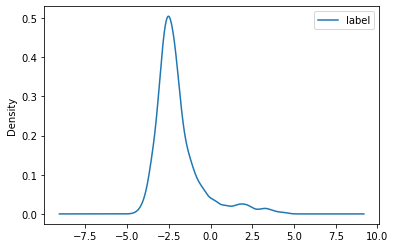

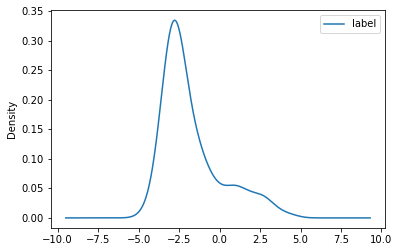

In [15]:
data.plot.kde()
test.plot.kde()

In [16]:
import torch
import random

SEED = 2022

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [28]:
def emoji2description(text):  
    return emoji.replace_emoji(text, replace=lambda chars, data_dict: ' '.join(data_dict['en'].split('_')).strip(':'))

def emoji2concat_description(text):
    emoji_list = emoji.emoji_list(text)
    ret = emoji.replace_emoji(text, replace='').strip()
    for json in emoji_list:
        this_desc = ' '.join(emoji.EMOJI_DATA[json['emoji']]['en'].split('_')).strip(':')
        ret += ' ' + this_desc
    return ret

def extract_emojis(text):
    emoji_list = emoji.emoji_list(text)
#     print(emoji_list)
    ret = []
    for json in emoji_list:
        this_emoji = json['emoji']
        ret.append(this_emoji)
    return ' '.join(ret)

def keep_only_emojis(data):
    cnt = data['content'].apply(emoji.emoji_count)
    return data[cnt >= 1]

def preprocess_string(s):
    # This cleans out all emojis!!!
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    return s

In [18]:
extract_emojis("I love 😄 it 😔 💗")

'😄 😔 💗'

In [19]:
from transformers import AutoTokenizer, AutoModel

In [20]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

In [21]:
# test if the tokenizer has emojis in its vocab
tokenizer.decode(tokenizer.encode('I love it 😄 😔 💗'))

'<s> I love it 😄 😔 💗</s>'

In [28]:
#data = keep_only_emojis(data)
#test = keep_only_emojis(test)

In [23]:
# X,y = data['content'].values, data['label'].values
# X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train, y_train = data['content'].values, data['label'].values
X_test, y_test = test['content'].values, test['label'].values
print(f'shape of train data is {X_train.shape}')
print(f'shape of test data is {X_test.shape}')

shape of train data is (8000,)
shape of test data is (554,)


In [29]:
class TweetDataset(Dataset):

    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweets = extract_emojis(str(self.tweets[item]))
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          tweets,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {
          'tweet_text': tweets,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.float32)
        }
    
def create_data_loader(X, y, tokenizer, max_len, batch_size):
    ds = TweetDataset(
    tweets=X,
    targets=y,
    tokenizer=tokenizer,
    max_len=max_len
    )

    return DataLoader(
    ds,
    batch_size=batch_size)

In [31]:
BATCH_SIZE = 16
MAX_LEN = 128

train_data_loader = create_data_loader(X_train, y_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(X_test, y_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [33]:
dataiter = iter(train_data_loader)
sample = dataiter.next()
print(sample.keys())
print(sample['input_ids'].shape)
print(sample['attention_mask'].shape)
print(sample['targets'].shape)

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])


## Model

In [19]:
bert = AutoModel.from_pretrained('xlm-roberta-base')

In [20]:
class BERT_BiLSTM_FFF_Cls(nn.Module):

    def __init__(self, bert, hidden_dim, bidirectional):
        super(BERT_BiLSTM_FFF_Cls, self).__init__()
        embedding_dim = bert.config.to_dict()['hidden_size']
        self.hidden_dim = hidden_dim
        self.bert = bert
        self.bidirectional = bidirectional
        
        self.lstm = nn.LSTM(input_size=embedding_dim,
                           hidden_size=self.hidden_dim,
                           num_layers=2,
                           bidirectional=self.bidirectional,
                           batch_first=True)
        
        self.drop = nn.Dropout(p=0.25)
        
        self.out = nn.Sequential(
                    nn.Linear(self.hidden_dim * 4, 512),
                    nn.ReLU(),
                    nn.Linear(512, 1)
                   )

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            embeddings = self.bert(
              input_ids=input_ids,
              attention_mask=attention_mask
            )[0]
        
        last_hidden = self.lstm(embeddings)[1][0]
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        last_hidden = self.drop(torch.flatten(last_hidden.transpose(0,1), start_dim=1, end_dim=2))
        
        return self.out(last_hidden).ravel()

In [33]:
hidden_dim = 512
bidirectional = True
EPOCHS = 20
lr=0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

baseline_1 = BERT_BiLSTM_FFF_Cls(bert, hidden_dim, bidirectional)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(baseline_1.parameters(), lr=lr)


## Training 

In [22]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )
#         print(outputs.dtype)
#         _,preds = torch.max(outputs, dim = 1)
        loss = loss_fn(outputs, targets)
#         prediction_error += torch.sum(torch.abs(targets - outputs))
#         correct_predictions += torch.sum(preds == torch.max(targets, dim = 1)[1])
#         print(f'Iteration loss: {loss.item()}')
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

#     return correct_predictions.double() / n_examples, np.mean(losses)
    return np.mean(losses), np.mean(losses)

In [60]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    output_all = torch.tensor([])
    target_all = torch.tensor([])
    output_all, target_all = output_all.to(device), target_all.to(device)
    with torch.no_grad():
        for d in data_loader:
            
            
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            target_all = torch.cat([target_all,targets])
            output_all = torch.cat([output_all,outputs])
#             _, preds = torch.max(outputs, dim=1)
#             prediction_error += torch.sum(torch.abs(targets - outputs))
            loss = loss_fn(outputs, targets)
            
#             correct_predictions += torch.sum(preds == torch.max(targets, dim = 1)[1])
            losses.append(loss.item())
#     return correct_predictions.double() / n_examples, np.mean(losses)
    return nn.functional.cosine_similarity(output_all, target_all, dim=0), np.mean(losses)

In [61]:
history = defaultdict(list)
best_accuracy = 0
baseline_1.to(device)

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
    baseline_1,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device,
    len(X_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
    baseline_1,
    test_data_loader,
    loss_fn, 
    device, 
    len(X_test)
    )

    print(f'Val   loss {val_loss} cos sim {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(baseline_1.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc